Pgeocode:https://pythonlang.dev/repo/symerio-pgeocode/ 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import chain
import pandas as pd
import datetime
import time
import os

## Useful functions

In [2]:
def list_slicer (l:list,c1:int,c2:int):
    # slice a non-numpy 2d list from column 1 (c1) to column 2 (c2)
    # return a 2d sublist
    result = []
    for row in l:
        result.append(row[c1:c2])
    return result


In [3]:

def getDateRangeFromWeek(p_year,p_week):
    '''
    # get week start & end date
    # in YYYYMMDD format
    '''
    start = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    f = start + datetime.timedelta(days=1) # otherwise first day of wk1 is last day of Dec
    l = f + datetime.timedelta(days=6.9)
    firstday = 10000*f.year+100*f.month + f.day
    lastday = 10000*l.year+100*l.month + l.day
    return firstday, lastday

#Call function to get dates range 
firstdate, lastdate =  getDateRangeFromWeek('2013','1')
print('print function ',firstdate,' ', lastdate)


print function  20130101   20130107


## Pygeocode

In [ ]:
import pgeocode
nomi = pgeocode.Nominatim('us')
nomi.query_postal_code("35224")

In [3]:
nomi.query_postal_code(["35205", "35224"])

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,35205,US,Birmingham,Alabama,AL,Jefferson,73.0,NaN,NaN,33.4951,-86.8059,4.0
1,35224,US,Birmingham,Alabama,AL,Jefferson,73.0,NaN,NaN,33.5191,-86.9342,4.0


In [4]:
# Distance calculations (km)
dist = pgeocode.GeoDistance('us')
dist.query_postal_code("35205", "35232")

12.68645971374117

## Station query

In [5]:
# convert station list to array
# there should be better ways but I didn't find any...
rows, cols = (119503, 9)
stations= [[0 for i in range(cols)] for j in range(rows)]
with open('ghcnd-stations.txt','r') as f:
    s = f.readlines()
i = 0
for station in s:
    stations[i][0]=station[:11] #ID
    stations[i][1]=float(station[12:20]) # Latitude
    stations[i][2]=float(station[21:30]) # Lontitude
    stations[i][3]=float(station[31:37]) # Elevatioin
    stations[i][4]=station[38:40].strip() # state
    stations[i][5]=station[41:71].strip() # name
    stations[i][6]=station[72:75].strip() # GSN flag
    stations[i][7]=station[76:79].strip() # HCN/CRN flag
    WMO = station[80:85].strip()
    if len(WMO)>0:
        stations[i][8]=int(WMO) # WMO ID
    else:
        stations[i][8]=""
    i +=1


In [6]:
# find all stations in a state
state = "AL"
state_all=[]
for row in stations:
    if row[4] == state:
        state_all.append(row)
        x = 0
#for r in state_all:
#    print(r)

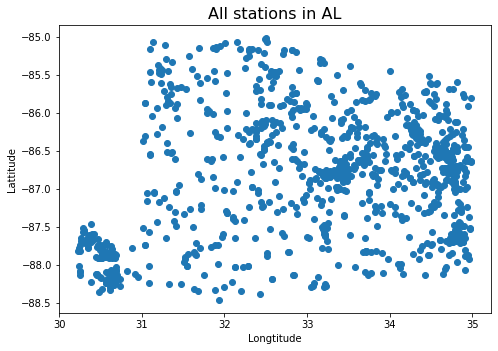

In [7]:
# plot all result stations

x = [i for v in list_slicer(state_all,1,2) for i in v] # all x coordinates
y = [i for v in list_slicer(state_all,2,3) for i in v] # all y coordinates
fig=plt.figure(0)
ax = fig.add_axes([0,0,1,1])
ax.scatter(x,y)
ax.set_ylabel("Lattitude")
ax.set_xlabel("Longtitude")
ax.set_title('All stations in ' +str(state), fontsize=16)
plt.show()


## Process .csv files in /by_year folder

In [4]:
# open a station file
import os
y1 = "2021"
filename = os.path.join("by_year", y1+".csv")
colnames = ['ID','Date','ELEM','VALUE','M-flag','Q-flag','S-Flag','ObsTime']
df = pd.read_csv(filename,names=colnames, header=None)
# df['Date'] = pd.to_datetime(df['YYYYMMDD'].astype(str), format='%Y%m%d')
#display(df.loc[50:60])
df.head()

,ID,Date,ELEM,VALUE,M-flag,Q-flag,S-Flag,ObsTime
0,AE000041196,20210101,TMAX,278,NaN,NaN,S,NaN
1,AE000041196,20210101,PRCP,0,D,NaN,S,NaN
2,AE000041196,20210101,TAVG,214,H,NaN,S,NaN
3,AEM00041194,20210101,TMAX,266,NaN,NaN,S,NaN
4,AEM00041194,20210101,TMIN,178,NaN,NaN,S,NaN


In [8]:
df2 = df.iloc[:,:4]
df2.head()

,ID,Date,ELEM,VALUE
0,AE000041196,20210101,TMAX,278
1,AE000041196,20210101,PRCP,0
2,AE000041196,20210101,TAVG,214
3,AEM00041194,20210101,TMAX,266
4,AEM00041194,20210101,TMIN,178


In [20]:
df2 = df2[["ID","ELEM","Date","VALUE"]]
df2.head()
#df.days=df.days.str[1:]

,ID,ELEM,Date,VALUE
0,AE000041196,TMAX,20210101,278
1,AE000041196,PRCP,20210101,0
2,AE000041196,TAVG,20210101,214
3,AEM00041194,TMAX,20210101,266
4,AEM00041194,TMIN,20210101,178


In [22]:
# reshape the dataframe
df3=pd.pivot_table(df2,index = ["ID","ELEM"],columns="Date",values = "VALUE")
df3.head()

Date              20210101  20210102  20210103  20210104  20210105  20210106  \
ID          ELEM                                                               
AE000041196 PRCP       0.0       0.0       0.0       0.0       0.0       0.0   
            TAVG     214.0     211.0     202.0     194.0     186.0     189.0   
            TMAX     278.0       NaN     273.0     273.0     272.0     273.0   
            TMIN       NaN       NaN       NaN     120.0      97.0     109.0   
AEM00041194 PRCP       0.0       0.0       0.0       0.0       0.0       0.0   

Date              20210107  20210108  20210109  20210110  ...  20211222  \
ID          ELEM                                          ...             
AE000041196 PRCP       0.0       0.0       0.0       0.0  ...       NaN   
            TAVG     189.0     182.0     173.0     165.0  ...     227.0   
            TMAX     264.0     261.0     255.0     262.0  ...       NaN   
            TMIN       NaN     108.0      74.0      78.0  ...       NaN   
AEM00041194 PRCP       0.0       0.0       0.0       0.0  ...       NaN   

Date              20211223  20211224  20211225  20211226  20211227  20211228  \
ID          ELEM                                                               
AE000041196 PRCP       NaN       NaN       NaN       NaN       NaN       NaN   
            TAVG     224.0     231.0     227.0     234.0     224.0     208.0   
            TMAX       NaN       NaN       NaN       NaN       NaN       NaN   
            TMIN       NaN       NaN       NaN       NaN       NaN       NaN   
AEM00041194 PRCP       NaN       NaN       NaN       NaN       NaN       NaN   

Date              20211229  20211230  20211231  
ID          ELEM                                
AE000041196 PRCP       NaN       NaN       NaN  
            TAVG     207.0     218.0     203.0  
            TMAX       NaN       NaN       NaN  
            TMIN       NaN       NaN       NaN  
AEM00041194 PRCP       NaN       NaN       NaN  

[5 rows x 365 columns]

In [134]:
# convert data format
# first for one station
cols = ["ID","Year","Elem","wk1","wk2","wk3","wk4","wk5","wk6","wk7","wk8","wk9",
                           "wk10","wk11","wk12","wk13","wk14","wk15","wk16","wk17","wk18","wk19","wk20","wk21","wk22",
                           "wk23","wk24","wk25","wk26","wk27","wk28","wk29","wk30","wk31","wk32","wk33","wk34","wk35",
                           "wk36","wk37","wk38","wk39","wk40","wk41","wk42","wk43","wk44","wk45","wk46","wk47","wk48",
                           "wk49","wk50","wk51","wk52"]
df_st1 = pd.DataFrame(columns =cols) # data from station 1 

for index, row in df4.iterrows():
    for wk in range (52):
        if ['STATION_ID']
        print(index,row['STATION_ID'], row['YYYYMMDD'],row['ELEMENT'],row['DATA VALUE'])



0 AE000041196 20210101 TMAX 278
1 AE000041196 20210101 PRCP 0
2 AE000041196 20210101 TAVG 214
3 AE000041196 20210102 PRCP 0
4 AE000041196 20210102 TAVG 211
5 AE000041196 20210103 TMAX 273
6 AE000041196 20210103 PRCP 0
7 AE000041196 20210103 TAVG 202
8 AE000041196 20210104 TMAX 273
9 AE000041196 20210104 TMIN 120
10 AE000041196 20210104 PRCP 0
11 AE000041196 20210104 TAVG 194
12 AE000041196 20210105 TMAX 272
13 AE000041196 20210105 TMIN 97
14 AE000041196 20210105 PRCP 0
15 AE000041196 20210105 TAVG 186
16 AE000041196 20210106 TMAX 273
17 AE000041196 20210106 TMIN 109
18 AE000041196 20210106 PRCP 0
19 AE000041196 20210106 TAVG 189
20 AE000041196 20210107 TMAX 264
21 AE000041196 20210107 PRCP 0
22 AE000041196 20210107 TAVG 189
23 AE000041196 20210108 TMAX 261
24 AE000041196 20210108 TMIN 108
25 AE000041196 20210108 PRCP 0
26 AE000041196 20210108 TAVG 182
27 AE000041196 20210109 TMAX 255
28 AE000041196 20210109 TMIN 74
29 AE000041196 20210109 PRCP 0
30 AE000041196 20210109 TAVG 173
31 AE00

530 AE000041196 20210608 TMIN 295
531 AE000041196 20210608 PRCP 0
532 AE000041196 20210608 TAVG 348
533 AE000041196 20210609 TMAX 385
534 AE000041196 20210609 TMIN 299
535 AE000041196 20210609 PRCP 0
536 AE000041196 20210609 TAVG 334
537 AE000041196 20210610 TMIN 286
538 AE000041196 20210610 PRCP 0
539 AE000041196 20210610 TAVG 339
540 AE000041196 20210611 PRCP 0
541 AE000041196 20210611 TAVG 336
542 AE000041196 20210612 TMIN 290
543 AE000041196 20210612 PRCP 0
544 AE000041196 20210612 TAVG 337
545 AE000041196 20210613 PRCP 0
546 AE000041196 20210613 TAVG 342
547 AE000041196 20210614 PRCP 0
548 AE000041196 20210614 TAVG 342
549 AE000041196 20210615 TMIN 286
550 AE000041196 20210615 PRCP 0
551 AE000041196 20210615 TAVG 346
552 AE000041196 20210616 TMIN 260
553 AE000041196 20210616 PRCP 0
554 AE000041196 20210616 TAVG 347
555 AE000041196 20210617 TMAX 403
556 AE000041196 20210617 TMIN 295
557 AE000041196 20210617 PRCP 0
558 AE000041196 20210617 TAVG 338
559 AE000041196 20210618 TMAX 407


In [18]:


getDateRangeFromWeek(str(year),)

No.of.unique values : 5
unique values : [165, 164, 158, 167, 160]
       height  weight  age
Steve     165    63.5   20
Ria       165    64.0   22
Nivi      164    63.5   22
Jane      158    54.0   21
Kate      167    63.5   23
Lucy      160    62.0   22
Ram       158    64.0   20
Niki      165    64.0   21


## Process .dly file in /all folder
These are text files which is named by stationID and each file has all daily data from that station

In [29]:
# open a station file
state = "AL"
s01 = "US1ALBL0007"
filename = os.path.join("all", s01+".dly")
print(filename)
with open(filename,'r') as f:
    records = f.readlines()

all\US1ALBL0007.dly


In [30]:
#convert the station file into an array
# globals()[stationID] convert the statonID to the variable 
# so that if stationID = "AL123", AL123 now becomes the variable
# i.e., the list name is "AL123", instead of "stationID"

l=(len(records))
rows,cols = (l,35)
i = 0
data_s01= [[0 for i in range(cols)] for j in range(rows)]
for r in records:
    data_s01[i][0]= r[0:11].strip() #ID
    data_s01[i][1]= int(r[11:15].strip()) #year
    data_s01[i][2]= int(r[15:17].strip()) #month
    data_s01[i][3]= r[17:21].strip() #element PRCP (tenths of mm); SNOW(mm); SNWD = Snow depth (mm)
                               # TMAX = Maximum temperature (tenths of degrees C)
                               # TMIN = Minimum temperature (tenths of degrees C)
    data_s01[i][4]="" if len(r[21:26].strip())==0 else int(r[21:26].strip()) #V1
    data_s01[i][5]="" if len(r[29:34].strip())==0 else int(r[29:34].strip()) #V2
    data_s01[i][6]="" if len(r[37:42].strip())==0 else int(r[37:42].strip()) #V3
    data_s01[i][7]="" if len(r[45:50].strip())==0 else int(r[45:50].strip()) #V4
    data_s01[i][8]="" if len(r[53:58].strip())==0 else int(r[53:58].strip()) #V5
    data_s01[i][9]="" if len(r[61:66].strip())==0 else int(r[61:66].strip()) #V6
    data_s01[i][10]="" if len(r[69:74].strip())==0 else int(r[69:74].strip()) #V7
    data_s01[i][11]="" if len(r[77:82].strip())==0 else int(r[77:82].strip()) #V8
    data_s01[i][12]="" if len(r[85:90].strip())==0 else int(r[85:90].strip()) #V9
    data_s01[i][13]="" if len(r[93:98].strip())==0 else int(r[93:98].strip()) #V10
    data_s01[i][14]="" if len(r[101:106].strip())==0 else int(r[101:106].strip()) #V11
    data_s01[i][15]="" if len(r[109:114].strip())==0 else int(r[109:114].strip()) #V12
    data_s01[i][16]="" if len(r[117:122].strip())==0 else int(r[117:122].strip()) #V13
    data_s01[i][17]="" if len(r[125:130].strip())==0 else int(r[125:130].strip()) #V14
    data_s01[i][18]="" if len(r[133:138].strip())==0 else int(r[133:138].strip()) #V15
    data_s01[i][19]="" if len(r[141:146].strip())==0 else int(r[141:146].strip()) #V16
    data_s01[i][20]="" if len(r[149:154].strip())==0 else int(r[149:154].strip()) #V17
    data_s01[i][21]="" if len(r[157:162].strip())==0 else int(r[157:162].strip()) #V18
    data_s01[i][22]="" if len(r[165:170].strip())==0 else int(r[165:170].strip()) #V19
    data_s01[i][23]="" if len(r[173:178].strip())==0 else int(r[173:178].strip()) #V20
    data_s01[i][24]="" if len(r[181:186].strip())==0 else int(r[181:186].strip()) #V21
    data_s01[i][25]="" if len(r[189:194].strip())==0 else int(r[189:194].strip()) #V22
    data_s01[i][26]="" if len(r[197:202].strip())==0 else int(r[197:202].strip()) #V23
    data_s01[i][27]="" if len(r[205:210].strip())==0 else int(r[205:210].strip()) #V24
    data_s01[i][28]="" if len(r[213:218].strip())==0 else int(r[213:218].strip()) #V25
    data_s01[i][29]="" if len(r[221:226].strip())==0 else int(r[221:226].strip()) #V26
    data_s01[i][30]="" if len(r[229:234].strip())==0 else int(r[229:234].strip()) #V27
    data_s01[i][31]="" if len(r[237:242].strip())==0 else int(r[237:242].strip()) #V28
    data_s01[i][32]="" if len(r[245:250].strip())==0 else int(r[245:250].strip()) #V29
    data_s01[i][33]="" if len(r[253:258].strip())==0 else int(r[253:258].strip()) #V30
    data_s01[i][34]="" if len(r[261:266].strip())==0 else int(r[261:266].strip()) #V31

    i+=1

In [31]:
# Check year range included the file
years = []
for rows in (data_s01):
    if rows[1] not in years:
        years.append(rows[1])
years.sort()
print(years)

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


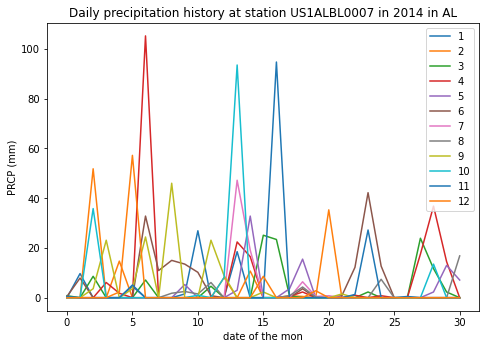

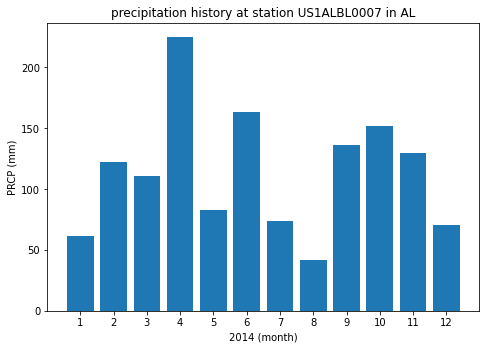

In [32]:
# find preciptation in a year
# known Problem: values are recalculated therefore incorrect if re-run this code block alone

year = 2014
element = "PRCP"
y_prcp = [] # whole year data
for row in data_s01:
    if row[1]==year:
        if row[3]==element:
            row[4:]=[0 if i ==-9999 else round(i/10,1) for i in row[4:]] # replace -9999 with 0
            #print(row)
            y_prcp.append(row[2:])

# plot daily prcp of each month
fig=plt.figure(1)
ax = fig.add_axes([0,0,1,1])
lg =[] # legend
for row in y_prcp:
    plt.plot(row[2:])
    lg.append(str(row[0]))
plt.legend(lg)
ax.set_ylabel(element+" (mm)")
ax.set_xlabel("date of the mon")
ax.set_title('Daily precipitation history at station '+str(s01)+' in '+str(year)+' in '+str(state))

m_prcp = [] # month total 
for row in y_prcp:
    m=(row[:2])
    m.append(round(sum(row[2:]),1))
    m_prcp.append(m)
#print(m_prcp)

# plot monthly sum 
fig=plt.figure(2)
ax = fig.add_axes([0,0,1,1])
mon =[] # legend
msum =[]
for row in m_prcp:
    msum.append(row[2])
    mon.append(str(row[0]))
ax.bar(mon,msum)
ax.set_ylabel(element+" (mm)")
ax.set_xlabel(str(year) + " (month)")
ax.set_title('precipitation history at station '+str(s01)+' in '+str(state))
plt.show()
